# Gaussian Processes

In this notebook we investigate the possibility to use gaussian process models to forecast the changes in bitcoin price. We treat the challenge as a regression problem, with the searched function's arguments being consequitive days in the dataset, and its values being the adjusted closing price values for given days. 

## Neccessary imports

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.contrib.timeseries as time_gp
from pyro.primitives import param
from torch.distributions import constraints 
from pyro.nn.module import PyroParam, PyroSample

import pandas as pd
from tqdm import tqdm
pyro.set_rng_seed(0)

We use a helper function to plot a model's prediction. Source: https://pyro.ai/examples/gp.html


In [2]:
def plot(
    X,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    xlim=None,
    train_test_split=None,
    line_color="r",
    title=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(X[0], X[-1], n_test, dtype=torch.double)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            mean, cov = model.forward(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            #color="C0",
            alpha=0.3,
        )
    if train_test_split:
        plt.axvline(x=len(X)-train_test_split, color='r')
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(X[0], X[-1])
    if title:
        ax.set_title(title)

We divide the data in this way that the last 200 days are treated as the test set, while the rest of the data is used for training. As this is a forecasting problem, we do not apply permutation.

As the price range is very high, we standarize the data by subtracting the mean of the train set and dividing by its standard deviation.

In [3]:
T0 = 200

In [4]:
df_price = pd.read_csv('../data/BTC-USD.csv', parse_dates=True)
df_price['Adj Close'] = df_price['Adj Close']
data = torch.tensor(df_price['Adj Close'].values, dtype=torch.double)
T_train = len(data) - T0

# standardize data
data_mean = data[0:T_train].mean(0)
data -= data_mean
data_std = data[0:T_train].std(0)
data /= data_std

In [5]:
X = torch.tensor(range(len(data[:-T0])), dtype=torch.double)
y = data[:-T0]

X_test = torch.tensor(range(len(data)-T0, len(data)), dtype=torch.double)
y_test = data[-T0:]




In [6]:
X_full = torch.tensor(range(len(data)), dtype=torch.double)
y_full = data

Helper function for plotting the loss function's values during training:

In [7]:

def plot_loss(loss, log=False, label=None):
    plt.plot(loss, label=label)
    if log:
      plt.yscale('log')
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text
    if label:
      plt.legend()



## Kernels
Kernel descriptions based on [Duv2014](https://www.cs.toronto.edu/~duvenaud/cookbook/) and [Scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html)


To find the optimal kernel for the task, we first check the basic types provided by Pyro. 

### Basic components used
*   Linear - linearly growing trend, useful mainly for combining with other functions
* Radial Basis Function (RBF) - popular, universal, smooth, in general non-monotonic function
* Rational Quadratic Kernel (RQ) - sum of many RBFs with different lengthscales, used for higher flexibility
* Mattern - generalization of RBF with an additional parameter v for regulating the smoothness of the functions. Explicitly implemented in Pyro for v=3/2 and v=5/2, as for lower values the process becomes too rough and higher values result with a similar effect to the plain RBF (see [Rasmussen](http://gaussianprocess.org/gpml/chapters/RW.pdf), pp. 85)
*   Periodic - repetitive behaviour over time periods



5it [06:40, 80.09s/it]


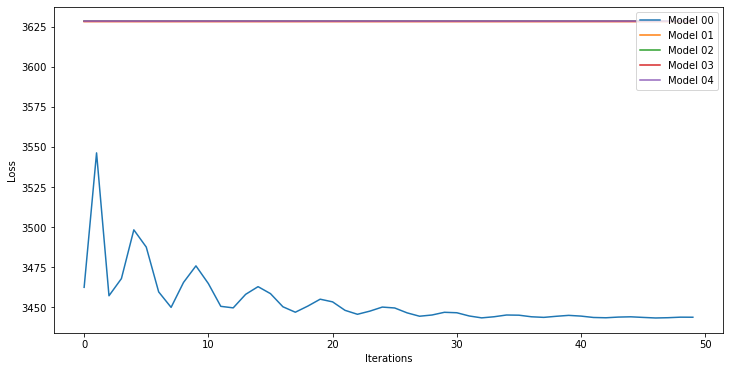

In [8]:
models_0 = []
pyro.clear_param_store()

models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.Linear(input_dim=1)))

models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.Periodic(input_dim=1)))

models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.RBF(input_dim=1)))
models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.RationalQuadratic(input_dim=1)))
models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.Matern32(input_dim=1)))
#models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.WhiteNoise(input_dim=1)))


fig, ax = plt.subplots(figsize=(12, 6))
for ii, model in tqdm(enumerate(models_0)):
    loss = gp.util.train(model, num_steps=50, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
    ax.plot(loss, label=f'Model 0{ii}')

# ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.legend(loc=1)

We visualise the predictions of the models below. The black "X" signs represent our data, the blue line depicts the mean of a model's predictions, while the semi-transparent blue area corresponds to an uncertainty given by two standard deviations. The red vertical line represents the threshold between the train set and the test set.

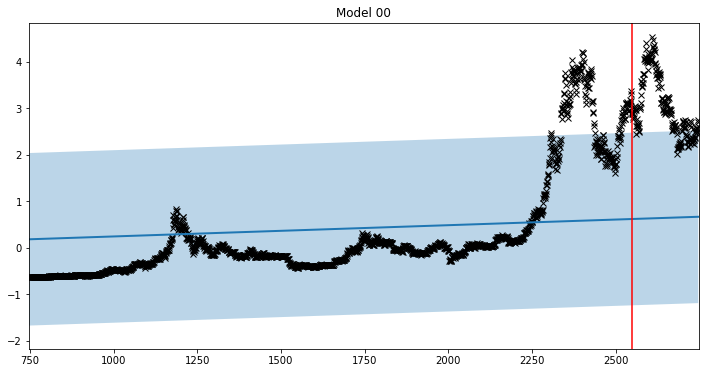

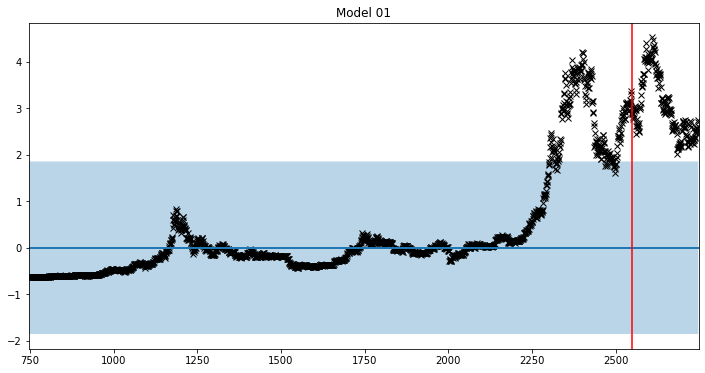

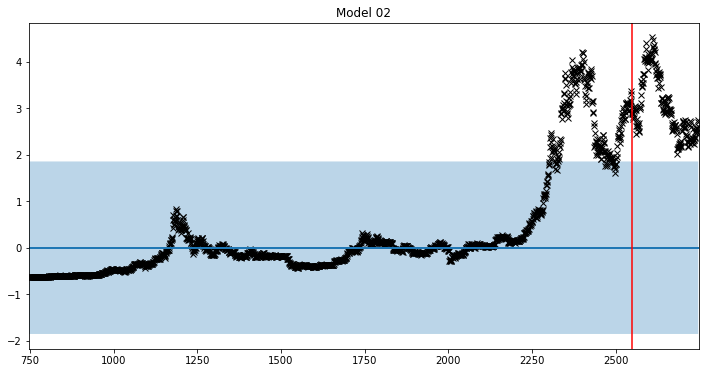

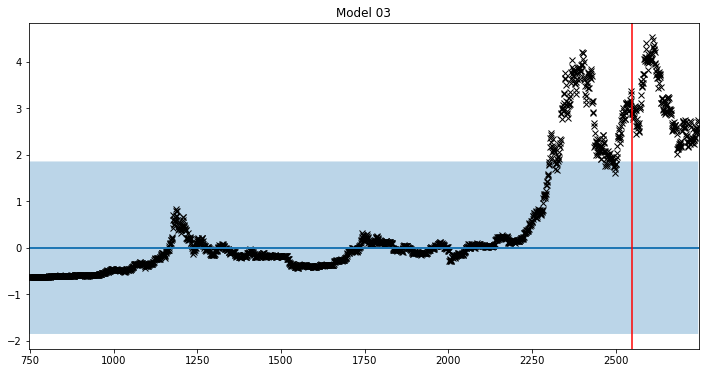

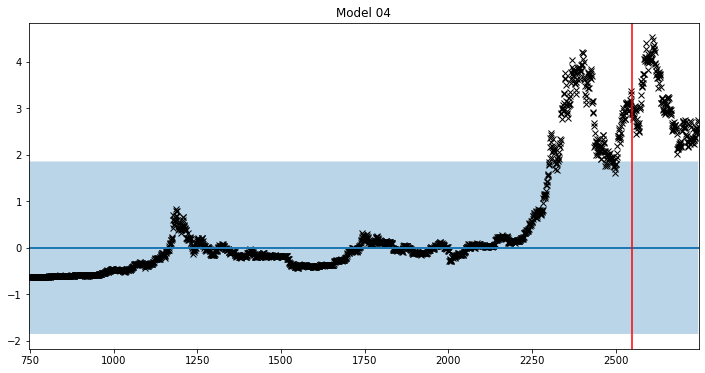

In [9]:
for i, model in enumerate(models_0):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(len(data)-10*T0, len(data)), train_test_split=T0, n_test=1000, title=f'Model 0{i}')

In [10]:
for ii, model in enumerate(models_0):
    print(f'Model 0{ii}')
    print(model.kernel)
    for kernel in model.kernel.named_parameters():
        print(kernel)

Model 00
Linear()
('variance_unconstrained', Parameter containing:
tensor(-15.8950, requires_grad=True))
Model 01
Periodic()
('variance_unconstrained', Parameter containing:
tensor(-15.8950, requires_grad=True))
('lengthscale_unconstrained', Parameter containing:
tensor(-1.0740, requires_grad=True))
('period_unconstrained', Parameter containing:
tensor(-0.5426, requires_grad=True))
Model 02
RBF()
('variance_unconstrained', Parameter containing:
tensor(-15.8950, requires_grad=True))
('lengthscale_unconstrained', Parameter containing:
tensor(-1.0740, requires_grad=True))
Model 03
RationalQuadratic()
('variance_unconstrained', Parameter containing:
tensor(-15.8950, requires_grad=True))
('lengthscale_unconstrained', Parameter containing:
tensor(-1.0740, requires_grad=True))
('scale_mixture_unconstrained', Parameter containing:
tensor(-2.5815, requires_grad=True))
Model 04
Matern32()
('variance_unconstrained', Parameter containing:
tensor(-15.8950, requires_grad=True))
('lengthscale_unconst

As clearly visible in the figures above, the simple-kernel models do not grasp the complexity of the timeseries. While a longer training with a smaller learning rate could yield slightly better results, we decided to build models with combined kernels. We expect that the variation of the BTC price over time is governed by several factors, including a non-monotonic growth due to the cryptocurrency's rising popularity, regular, periodic fluctuations of the market (for example over weekly/monthly/yearly basis) and an irregular term varying over longer periods of time. The following section describes the choice of the models.    


### Combined kernels

In principle, multiplying kernels result in a high kernel value only if all component "sub-kernels" have high values. On the contrary, adding kernels requires at least one component to have a high value to impact the whole sum. In particular, the following combinations were used:
* Locally Periodic - periodic kernel multiplied by a local one (e.g. RBF) to add long-term variation to the basic periodic
* Linear plus (Locally) Periodic - results in functions which are periodic with increasing amplitude as we move away from the origin


### Model 1
Baseline, inspired by [Pyro example](https://pyro.ai/examples/gp.html). In the context of Bitcoin price, linear kernel corresponds to an optimistic assumption that the price generally grows. The locally periodic component corresponds to close-to-regular market fluctuations. 

Kernel: Linear + RBF*Periodic

### Model 2
Instead of RBF, this model uses RQ in order ot have greater flexibility in mixing RBF-like lengthscales. It is hoped to address the fact that quasi-periodic market fluctuations in real life can have higher and varying amplitude than Model 1 assumes.

Kernel: Linear + RQ*Periodic

### Model 3

The local kernel is replaced by Mattern32 (Mattern with v=3/2) to represent short-term volatility of the price (rough RBF functions).

Kernal: Linear + Mattern32*Periodic

### Model 4

This model is purely locally periodic, so we abandon the assumption that there is a hidden linear trend in the data.

Kernal: RQ*Periodic

### Model 5

The kernel for this model does not include the periodic sub-kernel, assuming that periodic fluctuations are negligible. 
Kernal: Linear + RQ

5it [22:13, 266.61s/it]


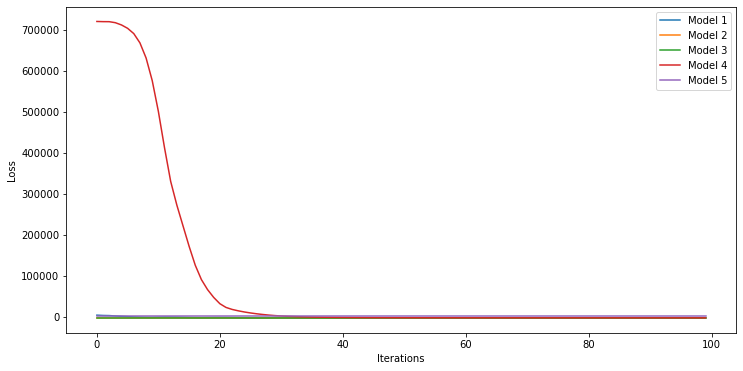

In [11]:
models = []
pyro.clear_param_store()

# Model 1: linear+RBF*periodic
kernel_1 = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RBF(input_dim=1)   
                              )
                          )
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_1))

# Model 2: linear+RQ*periodic

kernel_2 = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                          )

models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_2))


# Model 3: linear+Mattern32*periodic

kernel_3 = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.Matern32(input_dim=1)   
                              )
                          )
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_3))


# Model 4: RQ*periodic
kernel_4 = gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                      
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_4))

# Model 5: linear+RQ
kernel_5 = gp.kernels.Sum(
                              gp.kernels.Linear(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                      
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_5))








fig, ax = plt.subplots(figsize=(12, 6))
for ii, model in tqdm(enumerate(models)):
    loss = gp.util.train(model, num_steps=100, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
    ax.plot(loss, label=f'Model {ii+1}')

# ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.legend(loc=1)

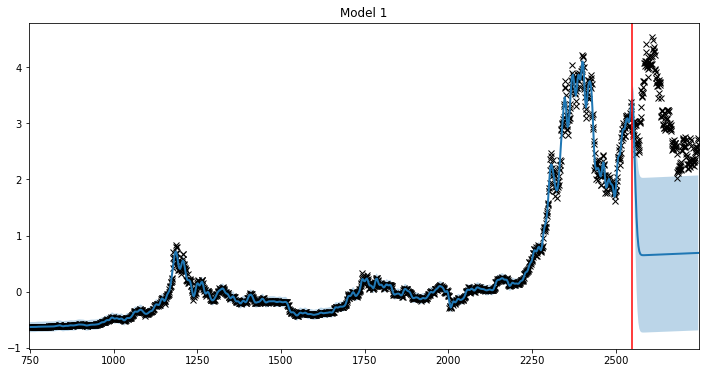

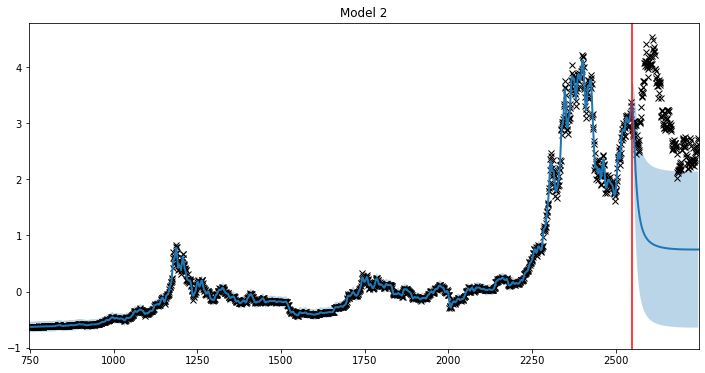

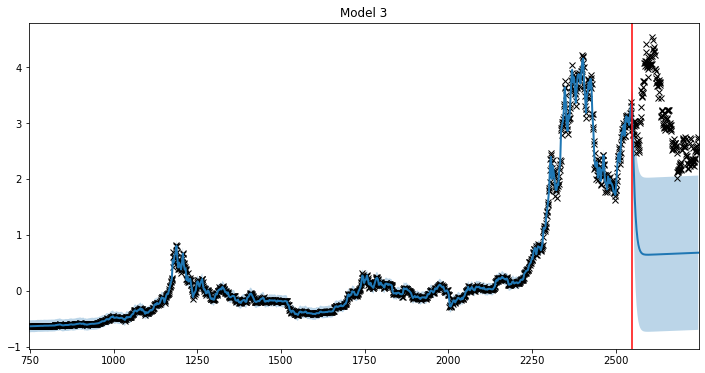

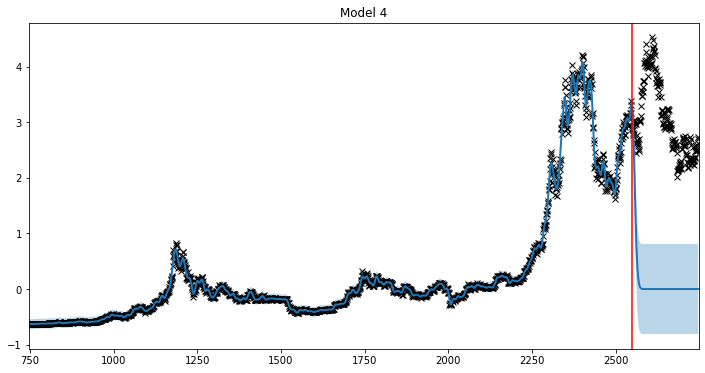

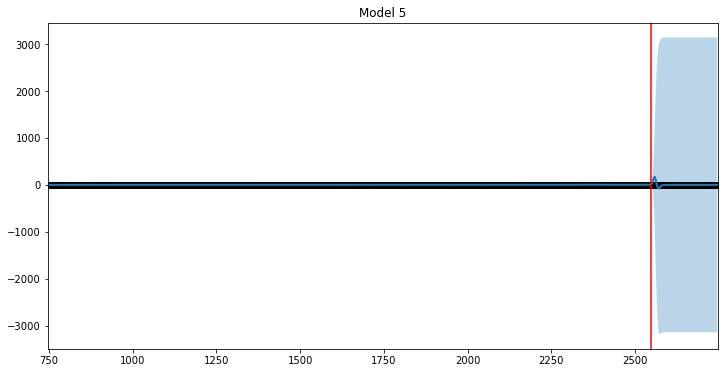

In [12]:
#colors = 'bgrcmyk'
#fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(models):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(len(data)-10*T0, len(data)), train_test_split=T0, n_test=1000, title=f'Model {i+1}')


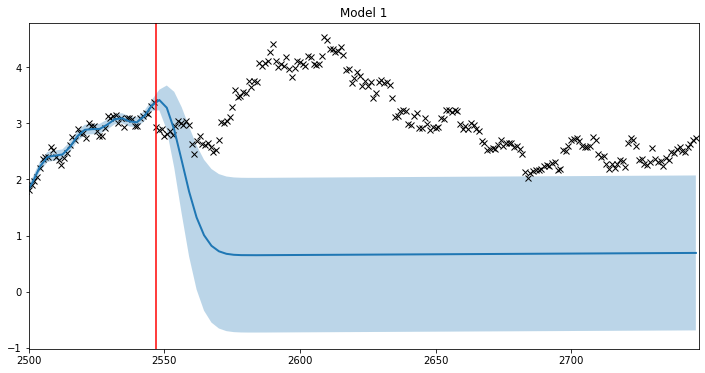

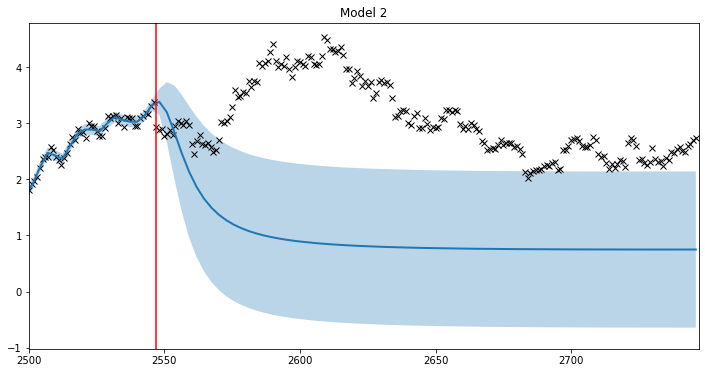

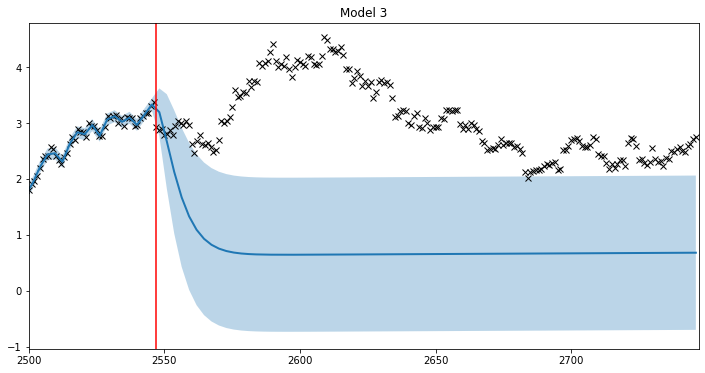

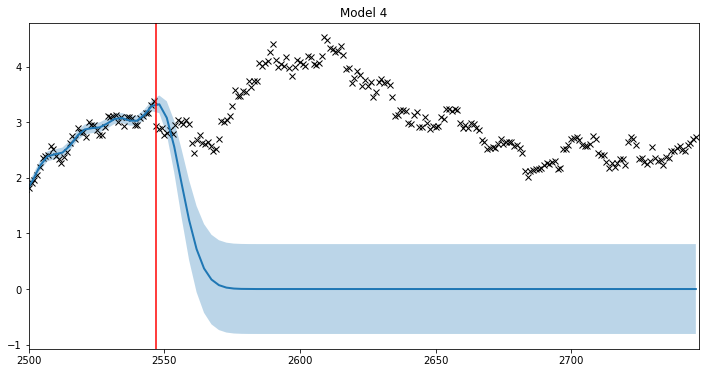

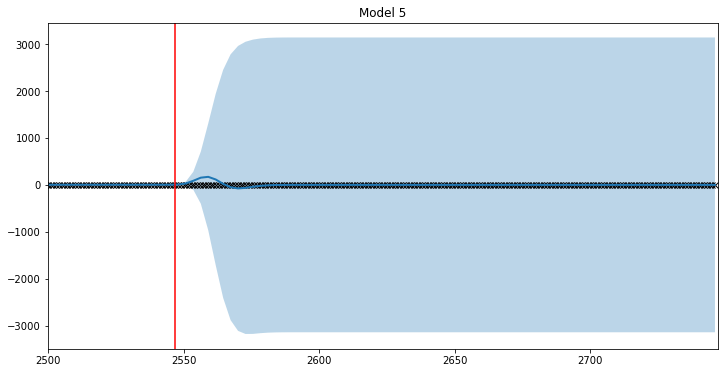

In [13]:
for i, model in enumerate(models):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(2500, len(data)), train_test_split=T0, n_test=1000, title=f'Model {i+1}')

In [14]:
for ii, model in enumerate(models):
    print(f'Model {ii+1}')
    print(model.kernel)
    for kernel in model.kernel.named_parameters():
        print(kernel)

Model 1
Sum(
  (kern0): Linear()
  (kern1): Product(
    (kern0): Periodic()
    (kern1): RBF()
  )
)
('kern0.variance_unconstrained', Parameter containing:
tensor(-16.5396, requires_grad=True))
('kern1.kern0.variance_unconstrained', Parameter containing:
tensor(-0.3870, requires_grad=True))
('kern1.kern0.lengthscale_unconstrained', Parameter containing:
tensor(6.7143, requires_grad=True))
('kern1.kern0.period_unconstrained', Parameter containing:
tensor(4.4504, requires_grad=True))
('kern1.kern1.variance_unconstrained', Parameter containing:
tensor(-0.3870, requires_grad=True))
('kern1.kern1.lengthscale_unconstrained', Parameter containing:
tensor(2.1298, requires_grad=True))
Model 2
Sum(
  (kern0): Linear()
  (kern1): Product(
    (kern0): Periodic()
    (kern1): RationalQuadratic()
  )
)
('kern0.variance_unconstrained', Parameter containing:
tensor(-16.5396, requires_grad=True))
('kern1.kern0.variance_unconstrained', Parameter containing:
tensor(-0.3870, requires_grad=True))
('kern1

To provide a more accurate measurement of the model's performance we evaluate the root mean squared error on the test set.

In [15]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [16]:
for ii, model in enumerate(models):
    rmse_tmp = sqrt(mse(y_test, model.forward(X_test)[0].detach().numpy()))
    print(f'Model {ii+1}, RMSE: {rmse_tmp}')

Model 1, RMSE: 2.3858950834538226
Model 2, RMSE: 2.2146242468865465
Model 3, RMSE: 2.4002857839955585
Model 4, RMSE: 3.009516769685169
Model 5, RMSE: 34.84555021598596


As visible above, none of the models managed to correctly predict the evolution of the bitcoin's price. This may be partially due to totally unconstrained parameters, so we decided to try to optimize two of the models - the best (model 2, linear+RQ*periodic) and the worst one (linear+RQ). 

## Model optimization

Here we investigate how the behaviour of model 2 changes if we apply a prior to the kernel parameters. We explore the parameter space by providing Half-Cauchy priors over the kernel's variance with increasing order of magnitude and by giving the periodic kernel's period as a normal distribution with mean corresponding to one day, a week, a month or a year. 

In [17]:
def local_periodic_rq(period_dist=None, variance_dist=None):
    kernel = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                          )
    if period_dist: 
        kernel.kern1.kern0.period = PyroSample(period_dist)
    if variance_dist: 
        kernel.kern1.kern0.variance = PyroSample(variance_dist)
    return kernel

4it [15:41, 235.37s/it]


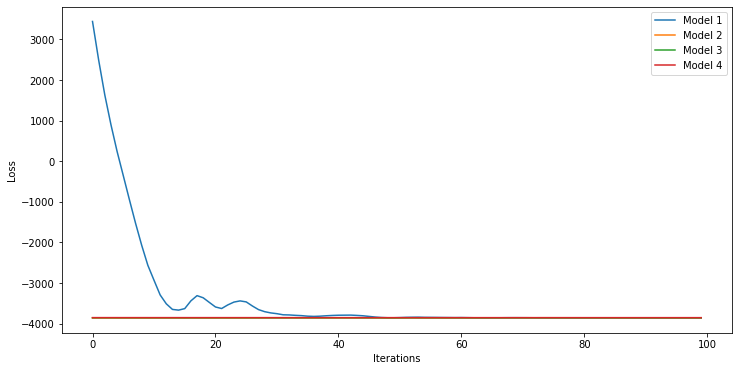

In [18]:
pyro.clear_param_store()
local_periodic_models = []


local_periodic_models.append(gp.models.GPRegression(X=X,y=y,kernel=local_periodic_rq(period_dist=dist.Normal(1, 1), variance_dist=dist.HalfCauchy(5))))
local_periodic_models.append(gp.models.GPRegression(X=X,y=y,kernel=local_periodic_rq(period_dist=dist.Normal(7, 1),variance_dist=dist.HalfCauchy(50))))
local_periodic_models.append(gp.models.GPRegression(X=X,y=y,kernel=local_periodic_rq(period_dist=dist.Normal(30, 7),variance_dist=dist.HalfCauchy(500))))
local_periodic_models.append(gp.models.GPRegression(X=X,y=y,kernel=local_periodic_rq(period_dist=dist.Normal(365, 30),variance_dist=dist.HalfCauchy(5000))))




fig, ax = plt.subplots(figsize=(12, 6))

for ii, model in tqdm(enumerate(local_periodic_models)):
    loss = gp.util.train(model, num_steps=100, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
    ax.plot(loss, label=f'Model {ii+1}')
    
# ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.legend(loc=1)

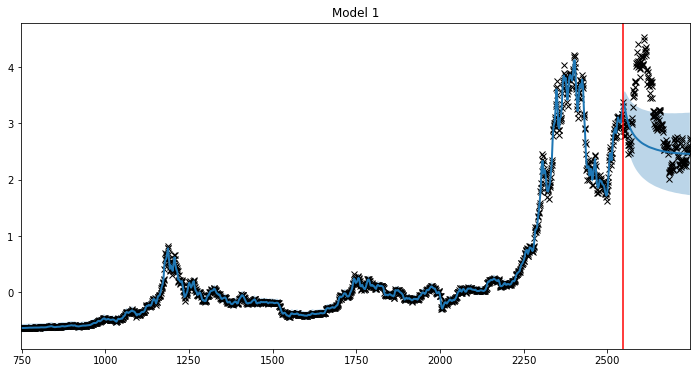

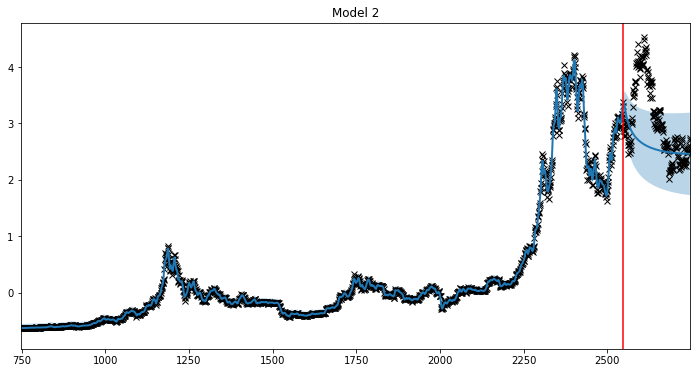

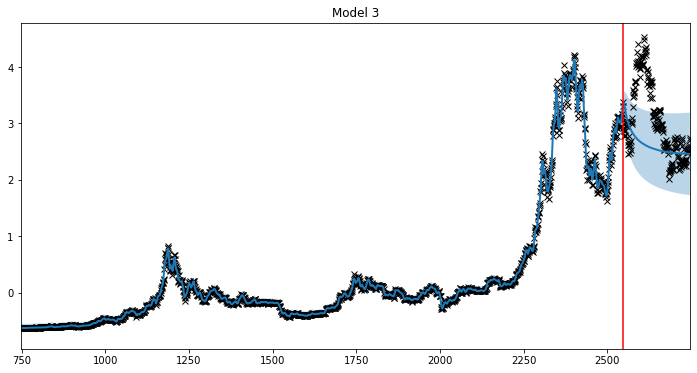

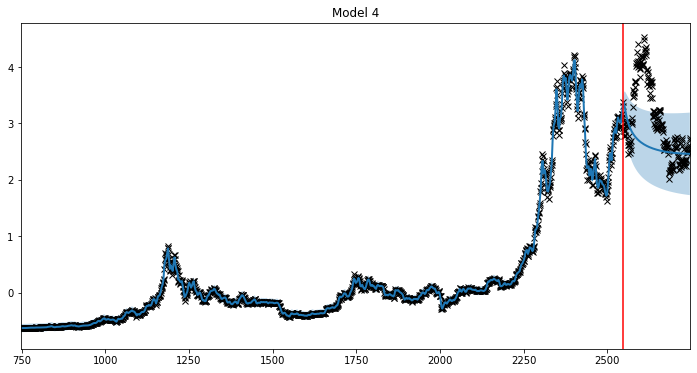

In [19]:
for i, model in enumerate(local_periodic_models):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(len(data)-10*T0, len(data)), train_test_split=T0, n_test=1000, title=f'Model {i+1}')

In [20]:
for ii, model in enumerate(local_periodic_models):
    rmse_tmp = sqrt(mse(y_test, model.forward(X_test)[0].detach().numpy()))
    print(f'Model {ii+1}, RMSE: {rmse_tmp}')

Model 1, RMSE: 0.7652315144106769
Model 2, RMSE: 0.7654059118233617
Model 3, RMSE: 0.7654200811442256
Model 4, RMSE: 0.7653795325687163


Both graphical evaluation and RMSE values indicate that the tested variants of model 2 have increased performance compared to the default version. Different parameters of the priors did not, however, seem to have a significant influence, as the values of the RMSE vary only after the fourth decimal place.


The next model we try to optimize is model 5 (linear+RQ). Here we apply a different sprategy and instead of giving a prior distribution over a parameter, we simply specify its initial value and let Pyro do the rest. Similar to the previous example, we explore the parameter space by increasing the order of the parameter's magnitude with each model.

In [21]:
def trendy_rq(rq_l_init=None, rq_a_init=None):
    kernel = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                          )
    if rq_l_init: 
        kernel.kern1.lengthscale = PyroParam(torch.tensor(rq_l_init))
    if rq_a_init: 
        kernel.kern1.scale_mixture = PyroParam(torch.tensor(rq_a_init))
    return kernel

4it [16:37, 249.44s/it]


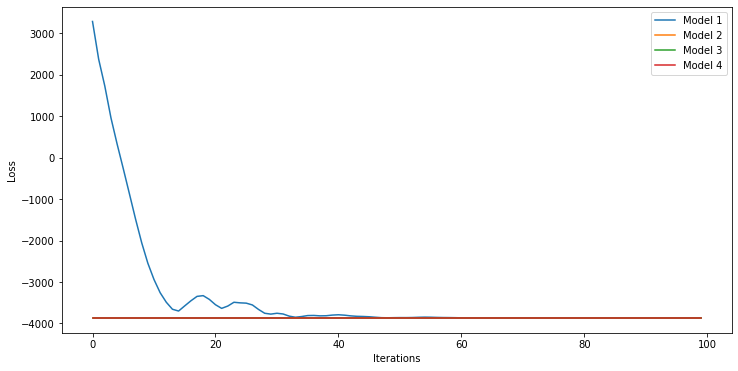

In [22]:
pyro.clear_param_store()
trendy_rq_models = []


trendy_rq_models.append(gp.models.GPRegression(X=X,y=y,kernel=trendy_rq(rq_l_init=5., rq_a_init=5.)))
trendy_rq_models.append(gp.models.GPRegression(X=X,y=y,kernel=trendy_rq(rq_l_init=50., rq_a_init=50.)))
trendy_rq_models.append(gp.models.GPRegression(X=X,y=y,kernel=trendy_rq(rq_l_init=500., rq_a_init=500.)))
trendy_rq_models.append(gp.models.GPRegression(X=X,y=y,kernel=trendy_rq(rq_l_init=5000., rq_a_init=5000.)))




fig, ax = plt.subplots(figsize=(12, 6))

for ii, model in tqdm(enumerate(trendy_rq_models)):
    loss = gp.util.train(model, num_steps=100, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
    ax.plot(loss, label=f'Model {ii+1}')
    
# ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.legend(loc=1)

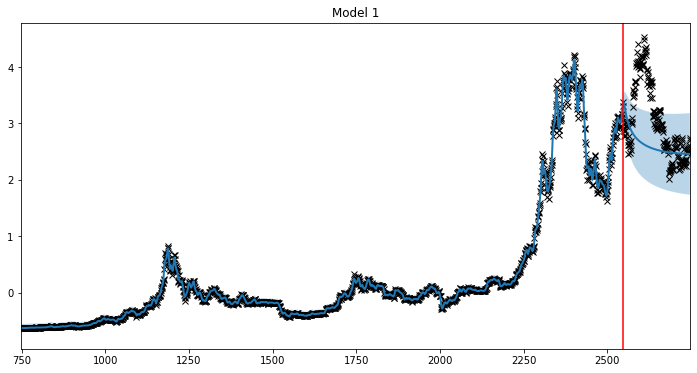

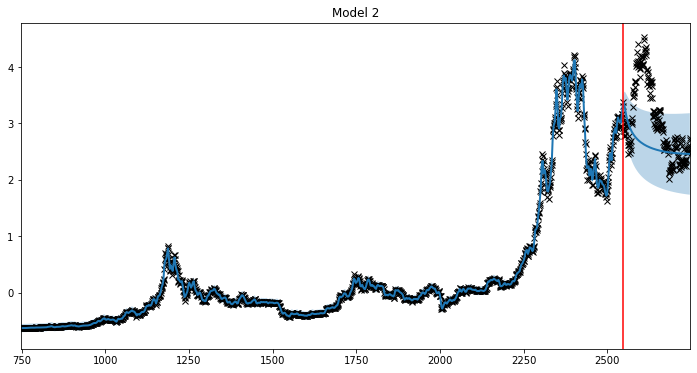

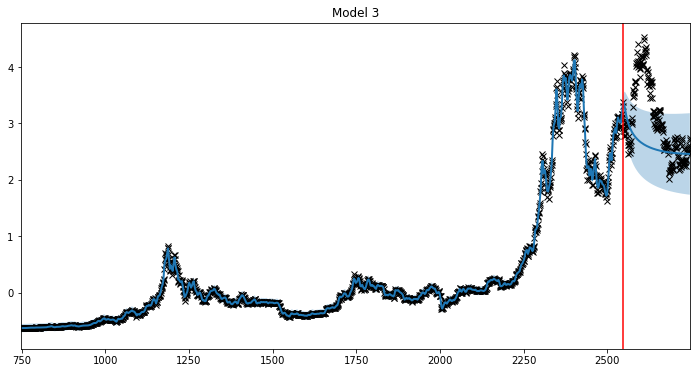

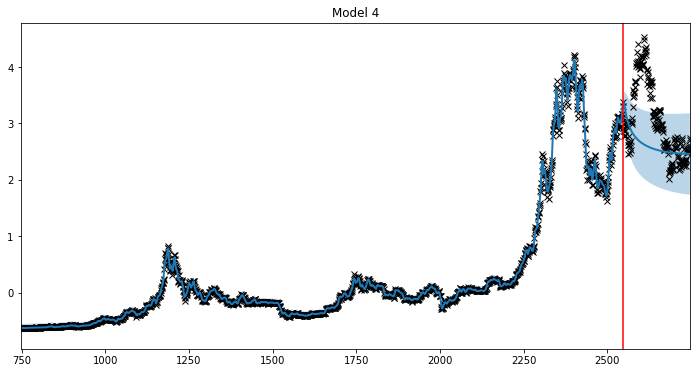

In [23]:
for i, model in enumerate(trendy_rq_models):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(len(data)-10*T0, len(data)), train_test_split=T0, n_test=1000, title=f'Model {i+1}')

In [24]:
for ii, model in enumerate(trendy_rq_models):
    rmse_tmp = sqrt(mse(y_test, model.forward(X_test)[0].detach().numpy()))
    print(f'Model {ii+1}, RMSE: {rmse_tmp}')

Model 1, RMSE: 0.7663242592587405
Model 2, RMSE: 0.7663242592587405
Model 3, RMSE: 0.7663242592587405
Model 4, RMSE: 0.7663242592587405


The performance of model 5 increased significantly, however its RMSE is in every case higher that RMSEs of the model 2's variants. While more experiments with more informed priors could provide even better results. This notebook suggests the locally periodic RQ kernel as a direction to pursue. 

## Optimal model: locally periodic RQ, with priors over the period and the variance

In [25]:
opti_model = models[1]

In [26]:
opti_model

GPRegression(
  (kernel): Sum(
    (kern0): Linear()
    (kern1): Product(
      (kern0): Periodic()
      (kern1): RationalQuadratic()
    )
  )
)